In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
roc_curve, auc, confusion_matrix, classification_report, brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPARATION

In [4]:
df = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [5]:
# def objective(trial):
#     params = {
#         'C': trial.suggest_float('C', 0.01, 10.0),
#         'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'sag', 'saga']),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000)
#     }
#     lr_clf = make_pipeline(preprocessor, LogisticRegression(**params))
#     cv_roc_auc = cross_val_score(lr_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
#     return cv_roc_auc


In [6]:
storage_name = "sqlite:///db.sqlite3_lr"
# # Random seeds - 42,50,58,66,72
# sampler = TPESampler(seed=72)
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="LR_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)


In [7]:
loaded_study = optuna.create_study(study_name="LR_one_day_assessment_final02", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-06 14:37:51,119] Using an existing study with name 'LR_one_day_assessment_final02' instead of creating a new one.


## Bootstraping and Calibration

In [8]:
# For Gradient Boosting
top_models_lr, results_lr, calibration_data_lr = bs_calibrate.new_bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, LogisticRegression, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data

In [9]:
joblib.dump(top_models_lr, 'results/bs_training_data/python_objects/top_models_lr.joblib')
joblib.dump(results_lr, 'results/bs_training_data/python_objects/results_lr.joblib')
joblib.dump(calibration_data_lr, 'results/bs_training_data/python_objects/calibration_data_lr.joblib')

['results/bs_training_data/python_objects/calibration_data_lr.joblib']

## Plotting and Calibration 

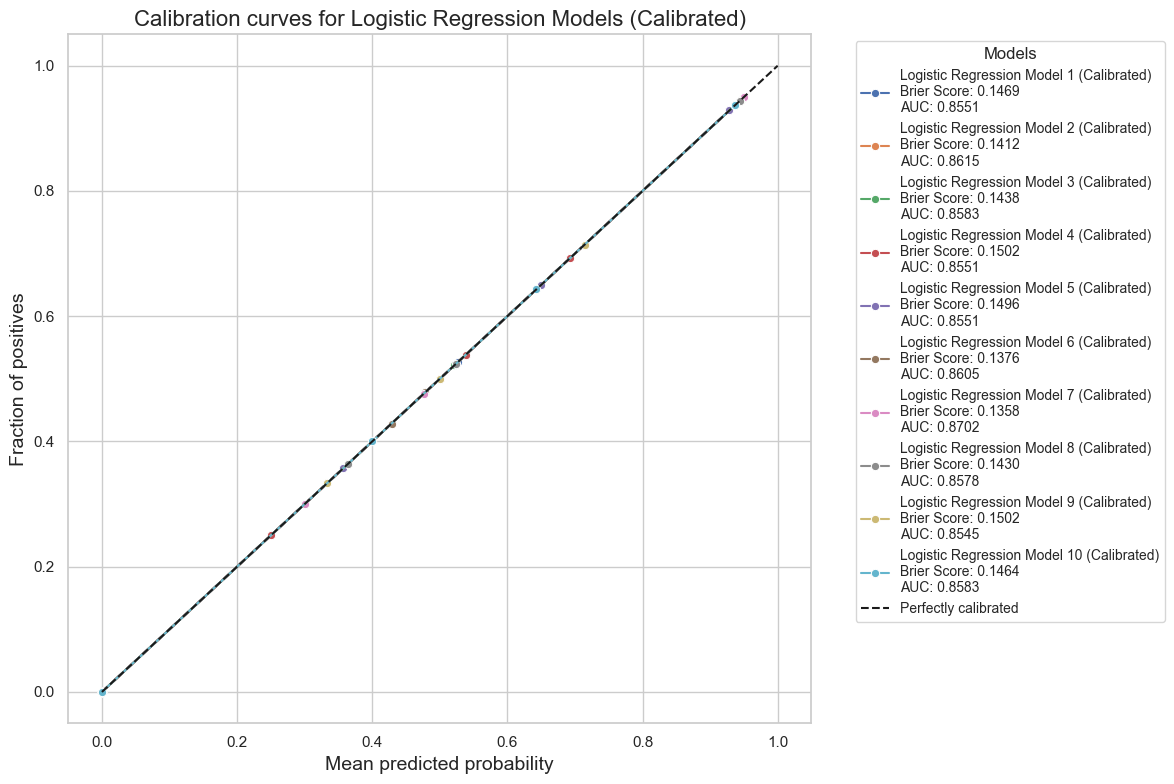

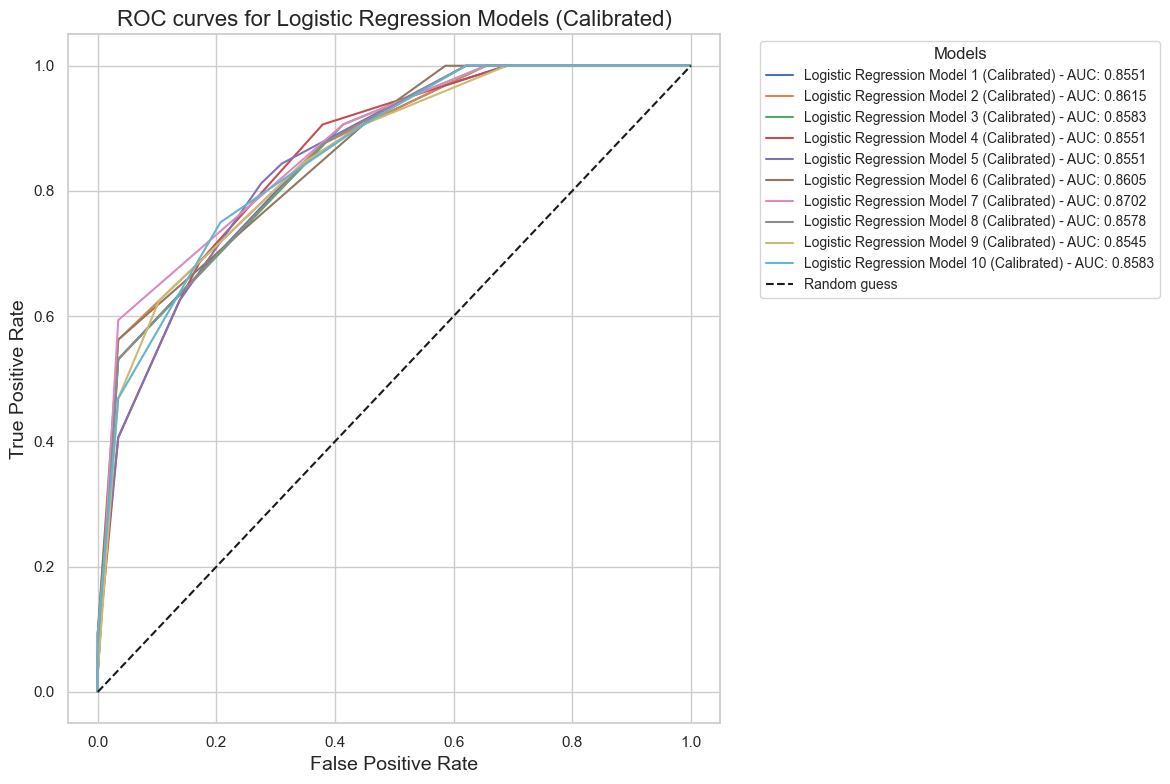

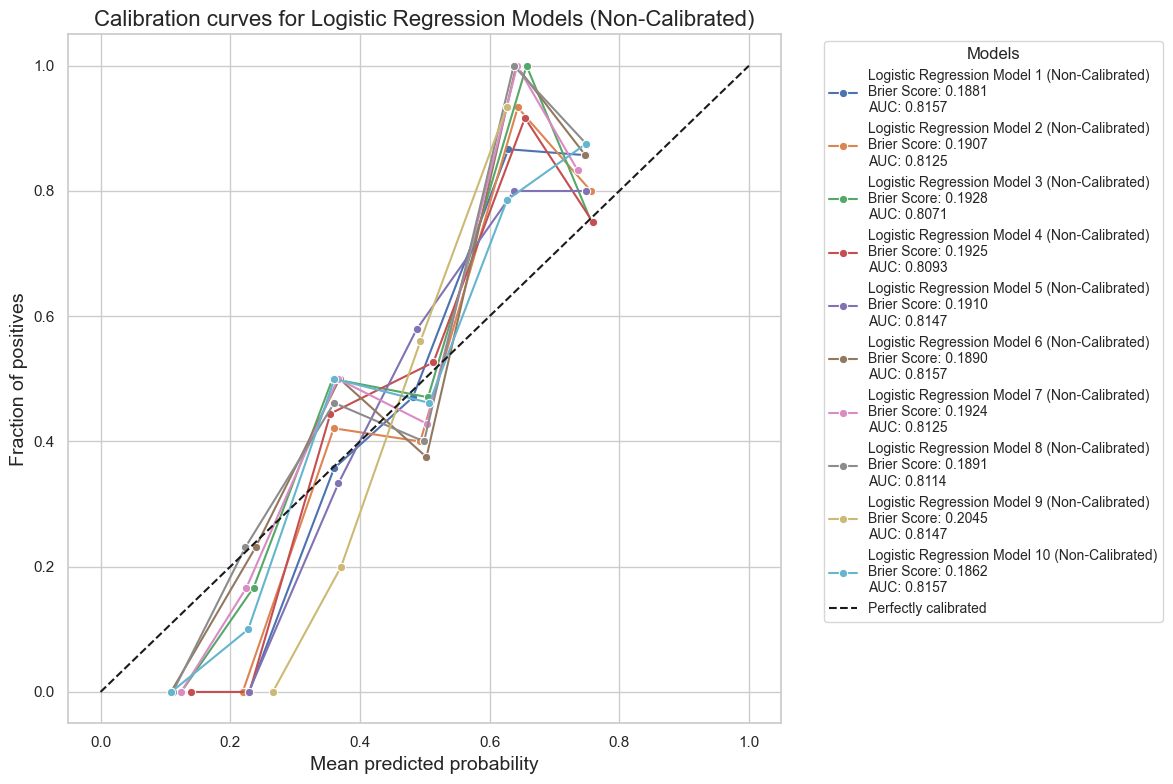

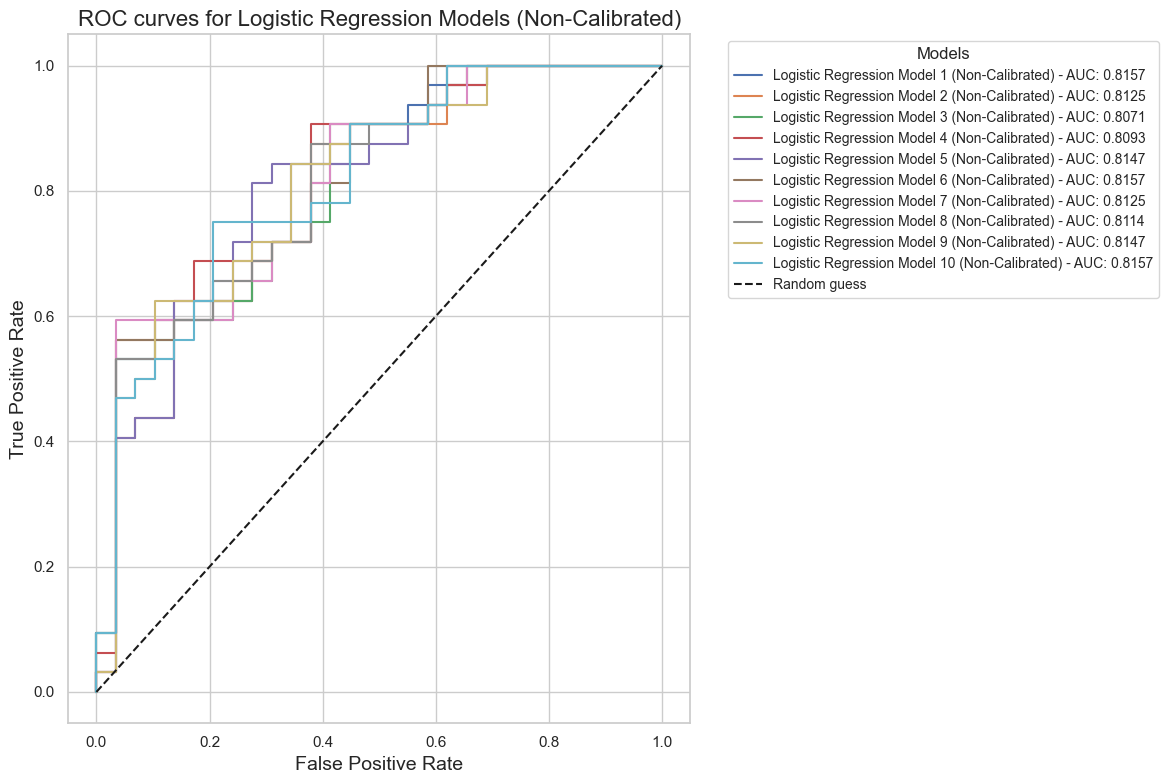

In [10]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('results/bs_training_data/python_objects/calibration_data_lr.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Logistic Regression", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Logistic Regression", calibrated=False)



## Extracting Feature Importance and save them in a csv file

In [11]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='results/bs_training_data/csv/feature_importances_lr.csv', 
                                                       model_name_prefix='lr', 
                                                       top_models_path='results/bs_training_data/python_objects/top_models_lr.joblib')

Data saved to - results/bs_training_data/csv/feature_importances_lr.csv


## Plot feature importance

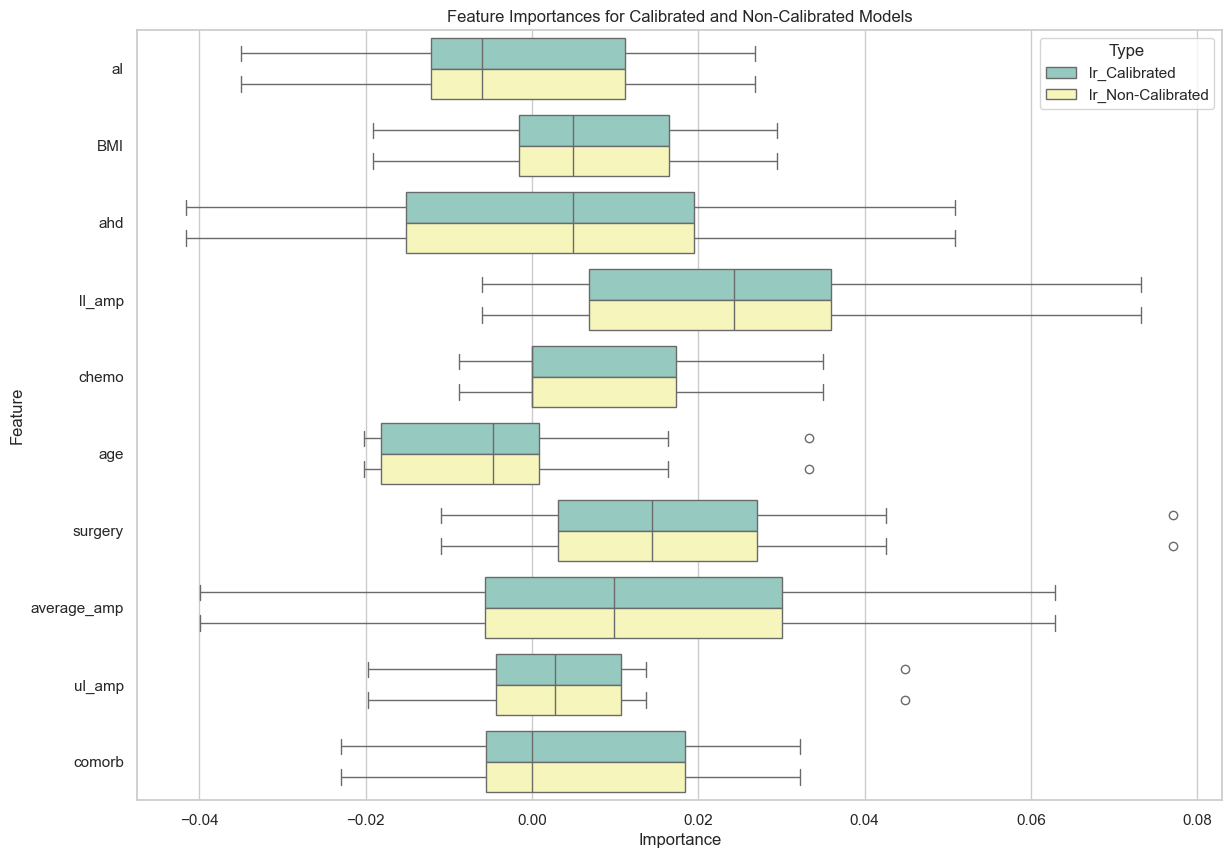

In [12]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for model in a csv file

In [13]:
loaded_results = joblib.load('results/bs_training_data/python_objects/results_lr.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.740557   0.771915  0.748906  0.746715  0.833588
std           0.012723   0.070372  0.132781  0.041855  0.008187
min           0.688525   0.681818  0.468750  0.612245  0.785022
max           0.786885   0.950000  0.937500  0.816901  0.870151
95% CI lower  0.715620   0.633986  0.488656  0.664680  0.817542
95% CI upper  0.765494   0.909844  1.009156  0.828751  0.849635

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.740557   0.771915  0.748906  0.746715  0.795928
std           0.012723   0.070372  0.132781  0.041855  0.008692
min           0.688525   0.681818  0.468750  0.612245  0.746767
max           0.786885   0.950000  0.937500  0.816901  0.815733
95% CI lower  0.715620   0.633986  0.488656  0.664680  0.778892
95% CI upper  0.765494   0.909844  1.009156  0.828751  0.812963


In [14]:
filename='results/bs_training_data/csv/final_results.csv'
model_name = 'LR'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to results/bs_training_data/csv/final_results.csv'

# Model Building without Bootstraping

In [15]:
non_bs_model, results_calibrated, results_non_calibrated = bs_calibrate.get_calibrated_model(X_t, y_t, X_v, y_v, preprocessor, 
                                                          LogisticRegression, best_params=best_params,
                                                         model_name_prefix="lr", csv_filename="results/non_bs_training_data/csv/model_metrics.csv")


Metrics saved to results/non_bs_training_data/csv/model_metrics.csv


In [16]:
results_calibrated['Brier Score'], results_non_calibrated['Brier Score']

(0.16322475338868783, 0.19233381677275388)

In [17]:
joblib.dump(non_bs_model, 'results/non_bs_training_data/models/non_bs_model_lr.joblib')
joblib.dump(results_calibrated, 'results/non_bs_training_data/python_objects/results_calibrated_lr.joblib')
joblib.dump(results_non_calibrated, 'results/non_bs_training_data/python_objects/results_non_calibrated_lr.joblib')

['results/non_bs_training_data/python_objects/results_non_calibrated_lr.joblib']